# 4. Modeling and Findings

**Kristian Newell**

**Course: BrainStation Data Science**

**Previous Notebook: 3. Feature Engineering**

Now that I have created a new `OrdinalTime` feature and `SouthAmerica` DataFrame, I am finished feature engineering and will proceed to modeling. My goal for this notebook is to create a predictive model that can help ease the burden of earthquakes. I will be performing supervised learning on the DataFrames that I have created in my past notebooks.

The first step that I hope to accomplish is to create a model that can predict the time between earthquakes. There are many smaller earthquakes in my dataset, and a prediction that every day there will be a small earthquake in my eyes is not as valuable as a model that can predict larger deadlier earthquakes that may occur only every few months or years. Because of this, I will be limiting my time series to larger earthquakes specifically. 

After this step I plan on using the predicted time to predict a Latitude and Longitude location. When regressing on Latitude and Longitude it is important to note that although on a globe 180W and 180S are extremely close to one another, the model interprets them as opposite sides of the distribution. The way that I will be fixing this is to focus only on South America and limit my Latitude and Longitude to this region.

To begin, I will be installing and loading all the necessary packages and models.

The following line is a packages that is not included in the base python library that I will be installing to use in modeling in this notebook.

In [5]:
conda install lightgbm

Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

# All requested packages already installed.



In [71]:
# The standard toolset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Date manipulation
import datetime

# Train test split
from sklearn.model_selection import train_test_split

# For regressions that only allow one output
from sklearn.multioutput import MultiOutputRegressor

# Grid Search
from sklearn.model_selection import GridSearchCV

# Scoring
from sklearn import metrics

# For checking residuals
import statsmodels.api as sm

# For checking if time series is stationary
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Modeling
from sklearn import ensemble
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

I am now going to read in my several datasets from the previous notebooks.

## Reading and Checking Data

In [7]:
# Setting working directory
os.chdir('C:/Users/Owner/Brainstation/Capstone')

# Reading in the whole dataset
earthquake_df=pd.read_csv('cleaned_df.csv')

# Reading in the South American data
SouthAmerica_df=pd.read_csv('SouthAmerica_df.csv')

# Reading in the large earthquake data
big_earthquake_df=pd.read_csv('big_earthquake_df.csv')

I am now going to create a new DataFrame that has in it only the overlap between the `big_earthquake` and `SouthAmerica` DataFrames so that I can have only the large earthquakes in South America.

In [8]:
# Using an inner join on the two datasets so that only observations included in both appear
big_SouthAmerica_df = pd.merge(big_earthquake_df, SouthAmerica_df, how='inner')

In [9]:
# Checking the amount of obserations in the new DataFrame compared to the originals
print(f'big_earthquake_df observations: {big_earthquake_df.shape[0]}')
print(f'SouthAmerica_df observations: {SouthAmerica_df.shape[0]}')
print(f'big_SouthAmerica_df observations: {big_SouthAmerica_df.shape[0]}')

big_earthquake_df observations: 738
SouthAmerica_df observations: 1971
big_SouthAmerica_df observations: 88


The observations dropped significantly from our original two DataFrames, which we expected since the filters I am using are quite restrictive. I am now going to check that the data is formatted correctly.

In [10]:
# Inspecting the resulting DataFrame
big_SouthAmerica_df

,Latitude,Longitude,Magnitude,Depth,DateAndTime
0,-25.6330,-70.6790,7.0,35.00,1965-02-23 22:11:47
1,-32.5220,-71.2330,7.4,70.00,1965-03-28 16:33:16
2,-10.6650,-78.2280,8.1,40.00,1966-10-17 21:42:00
3,-25.4940,-70.5500,7.7,25.00,1966-12-28 08:18:07
4,2.8490,-74.7980,7.0,55.00,1967-02-09 15:24:49
...,...,...,...,...,...
83,-31.5622,-71.4262,7.0,28.41,2015-09-16 23:18:42
84,-10.5372,-70.9437,7.6,606.21,2015-11-24 22:45:39
85,-10.0598,-71.0184,7.6,620.56,2015-11-24 22:50:54
86,0.3819,-79.9218,7.8,20.59,2016-04-16 23:58:37


In [11]:
# Checking the columns and data types
big_SouthAmerica_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 0 to 87
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Latitude     88 non-null     float64
 1   Longitude    88 non-null     float64
 2   Magnitude    88 non-null     float64
 3   Depth        88 non-null     float64
 4   DateAndTime  88 non-null     object 
dtypes: float64(4), object(1)
memory usage: 4.1+ KB


The `DateAndTime` column has been set to an object again, so I will be fixing that.

In [12]:
# Recasting as datetime
big_SouthAmerica_df['DateAndTime']=pd.to_datetime(big_SouthAmerica_df['DateAndTime'])

In [13]:
# Checking to see that the data type has changed
big_SouthAmerica_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 0 to 87
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Latitude     88 non-null     float64       
 1   Longitude    88 non-null     float64       
 2   Magnitude    88 non-null     float64       
 3   Depth        88 non-null     float64       
 4   DateAndTime  88 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.1 KB


The data now looks correct with the exception of the absence of my ordinal time feature. I am now going to recreate it in this DataFrame.

In [14]:
# Making Datetime as a list of seconds so I can use it in the regression
big_SouthAmerica_df['OrdinalTime']=big_SouthAmerica_df['DateAndTime'].apply(lambda x:x.toordinal())

The correct packages are imported and the data is formatted correctly, It is now time to begin modeling. The plan is to begin with time series to see if I am able to create an accurate predictor of time between large earthquakes in South America.

## Modeling

### Time Series

The first step in time series prediction is to set the index to datetime. To ensure that this does not affect my DataFrame I am going to take a copy of it for time series analysis.

In [15]:
# Copying my big South America DataFrame
time_df=big_SouthAmerica_df.copy()

In [16]:
# Setting datetime to my index column
time_df.set_index('DateAndTime',inplace=True)

In [17]:
# Sorting my index to get a chronological ordering of my data
time_df.sort_index(inplace=True)
time_df.head(10)

,Latitude,Longitude,Magnitude,Depth,OrdinalTime
DateAndTime,,,,,
1965-02-23 22:11:47,-25.633,-70.679,7.0,35.0,717390
1965-03-28 16:33:16,-32.522,-71.233,7.4,70.0,717423
1966-10-17 21:42:00,-10.665,-78.228,8.1,40.0,717991
1966-12-28 08:18:07,-25.494,-70.550,7.7,25.0,718063
1967-02-09 15:24:49,2.849,-74.798,7.0,55.0,718106
1967-02-15 16:11:12,-9.163,-71.274,7.0,600.4,718112
1967-09-03 21:07:29,-10.656,-79.674,7.0,15.0,718312
1967-12-21 02:25:26,-21.865,-69.939,7.3,45.0,718421
1970-05-31 20:23:29,-9.183,-78.737,7.9,45.0,719313


Now that I have set datetime as my index, I am going to separate out my train(X) and test(y). I will begin by defining y as my `Latitude` and `Longitude` features indexed by time. 

In [18]:
# Creating a y matrix of just lat/long and datetime
y=time_df[['Latitude','Longitude']]

# Renaming the index as it gets wordy after the above row of code
y.index.rename('date',inplace=True)
y.head()

,Latitude,Longitude
date,,
1965-02-23 22:11:47,-25.633,-70.679
1965-03-28 16:33:16,-32.522,-71.233
1966-10-17 21:42:00,-10.665,-78.228
1966-12-28 08:18:07,-25.494,-70.550
1967-02-09 15:24:49,2.849,-74.798


I am now going to plot my new time series y on a graph to look at its values over time.

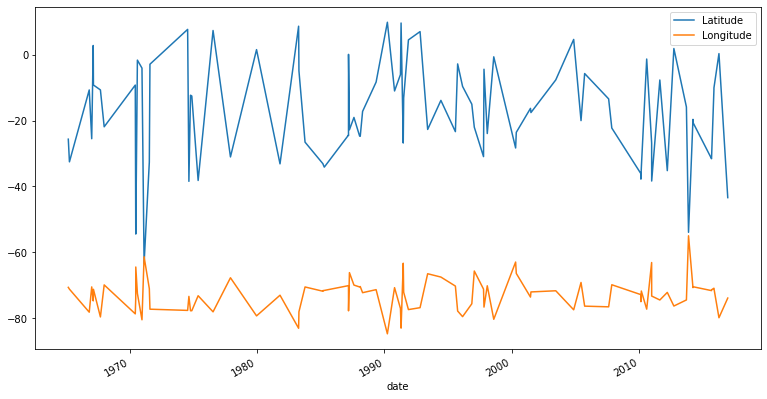

In [19]:
# visualizing
ax=y.plot(figsize=(13,7))

I am going to create the X DataFrame by splitting my y DataFrame in two, data before January 1st 2010 and data after January 1st 2010. I have chosen this date because the graph above indicates that roughly 70-80% of my data comes before 2010, and that is roughly the train/test split that I want.

In [20]:
# Creating my train/test split by sectioning off all observations before 2010
X=y[y.index<='2010-01-01 00:00:00']
y=y[y.index>'2010-01-01 00:00:00']

In [21]:
# Checking the lengths of my x and y to be sure the split worked correctly and there is a good distribution of observations between them
print(X.shape[0])
print(y.shape[0])

69
19


After splitting we can see that 69 of our 88 data points are in the X DataFrame. This is a good distribution, seeing how roughly 78% of our data belongs to the training set and 12% belongs to the test set. I am now going to plot the two time series so that I can better visualize the split.

<function matplotlib.pyplot.show(close=None, block=None)>

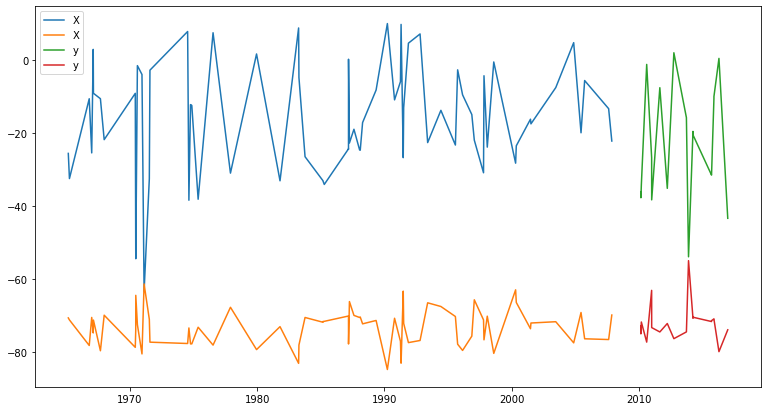

In [22]:
# Visualizing the split of X and y
plt.figure(figsize=(13,7))
plt.plot(X, label='X')
plt.plot(y, label ='y')
plt.legend()
plt.show

My X and y variables have been separated correctly and should be now able to be used in my forecasting. Before I begin attempting to forecast with my time series I need to confirm that there is no cointegration between the variables in my time series.

In [23]:
# Checking if the time series is stationary
johan_test_temp = time_df
coint_johansen(johan_test_temp,-1,1).eig

array([0.48925355, 0.43853983, 0.33814592, 0.30098277, 0.22179706])

The Johansen cointegration test (by outputting large positive values) has determined that there is cointegration between at least two of my time series present in this DataFrame, meaning that the resulting time series forecast will be inaccurate. 

Due to this, I will be unable to create an accurate time series, instead I will focus on given time and location, predicting the depth and magnitude of resulting earthquakes. Although this model would only be able to predict the Magnitude and Depth of a an earthquake, this could still help countries prepare for large earthquakes if it were integrated with any seismic early warning systems.

### Predicting Magnitude and Depth Given Latitude, Longitude, and Time

I am going to continue on by predicting the Depth and Magnitude features of my dataset by using `Latitude`, `Longitude`, and `DateAndTime`. For all the models I test, I will be using mean squared error as the metric of score since all my data is numeric. I will continue using the DataFrame I created of large earthquakes specifically in South America, both because I think this area could benefit greatly from early warning mechanisms to protect against earthquakes as well as the fact that specifying one area removes the wrapping issue with longitude on a globe.

I will begin by separating my features(X) from my targets(y), and creating a validation and test set for X and y.

In [24]:
# Setting up X and y
X = big_SouthAmerica_df[['Latitude', 'Longitude','OrdinalTime']]
y= big_SouthAmerica_df[['Depth','Magnitude']]

# Train test splitting
X_data, X_test, y_data, y_test = train_test_split(X, y,test_size=0.2,random_state=13)

# Creating a validation set
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data,test_size=0.2,random_state=13)

I will begin with the most basic regression models to see how a simple models do on predicting. Ideally if a simple model is able to capture a large amount of variance in the data more complex models will not be required.

In [25]:
# Running Linear Regressor
Lin_reg = LinearRegression().fit(X_train, y_train)
Lin_reg.score(X_val, y_val)

0.16961925795058796

The scoring metric above indicates that the R squared value is 0.1696. This means that ~17% of the variance in our data is explained by a linear model. This is not a significant enough amount to be content with a model.

Next I will be running a random forest regressor.

In [26]:
# Running Random Forest Regressor, choosing somewhat arbitrary hyperparameters
RF_reg = RandomForestRegressor(n_estimators=40,max_depth=5,min_samples_leaf=3, random_state=13)
RF_reg.fit(X_train, y_train)
RF_reg.score(X_val, y_val)

0.18141771546264412

Although the score has increased to 0.18, meaning roughly 1% more variance captured in this model than the linear regressor, this is still not enough to be content with a model. 

Next I will be running a gradient boosting regressor.

In [27]:
# Running a Gradient Boosting Regressor
multi_reg=MultiOutputRegressor(GradientBoostingRegressor(random_state=13,loss='quantile')).fit(X_train, y_train)
multi_reg.score(X_val, y_val)

-0.3221277666809219

This regression model is reporting a negative number, meaning it is not fit to predict on this dataset.

Next I will be running another gradient-boosting regressor, the LightGBM regressor.

In [28]:
# Running a LGBM Regressor
lgbm_reg= MultiOutputRegressor(LGBMRegressor(random_state=13))
lgbm_reg.fit(X_train,y_train)
lgbm_reg.score(X_val,y_val)

0.08851785103758453

This model had the lowest absolute score reported of all the models we have tested so far.

Next I will be running an XGBoost regressor.

In [29]:
# Running a XGBoost Regressor
xgb_reg=MultiOutputRegressor(XGBRegressor(random_state=13))
xgb_reg.fit(X_train,y_train)
xgb_reg.score(X_val,y_val)

-0.5222406237798338

This model also output a negative number meaning it did not do well predicting on our data. 

There were several models I tried in this step with somewhat arbitrary or default hyperparameters that resulted in poor predictions. I imagine that these models have the potential to match my data significantly better if their hyperparameters are optimized. To do this I will be creating a series of functions to gridsearch over each of these models to optimize their hyperparameters.

In [39]:
# Function definition for grid searches over my 4 models: Random Forest Regressor, Gradient Boost Regressor, Light GBM Regressor, and XGB Regressor

def Grid_Search_CV_RFR(X_train, y_train):

        '''Outputs the best parameters and best score of a gridsearch over several RandomForestRegressor hyperparameters.'''

        # Instantiating a Random Forest Regressor
        estimator = RandomForestRegressor(random_state=13)

        # Setting up the parameter grid I wish to test
        param_grid = { 

            'n_estimators'      : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,40,50,60,70,80,90,100,110,150,180,200,220,300],
            'max_features'      : ['auto', 'sqrt', 'log2'],
            'min_samples_split' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
            'bootstrap'         : [True, False],
            }

        # Instatiating the grid search
        grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

        # Fitting Grid search to my data
        grid.fit(X_train, y_train)

        # Returning the best parameters for my data
        return grid.best_params_


def Grid_Search_CV_GBR(X_train, y_train):

        '''Outputs the best parameters and best score of a gridsearch over several Gradient Boost Regressor hyperparameters.'''

        # Instantiating a Gradient Boost Regressor
        estimator = MultiOutputRegressor(GradientBoostingRegressor(random_state=13,criterion='mse',subsample=0.95))

        # Setting up the parameter grid I wish to test
        param_grid = {
             
            'estimator__n_estimators'      : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,40,50,60,70,80,90,100,110,150,180],
            'estimator__learning_rate'     : [.001,.005,.01,.05,.1],
            'estimator__min_samples_split' : [2,3,4,5,6],
            'estimator__min_samples_leaf'  : [1,2,3,4,5,6],
            'estimator__max_depth'         : [2,3,4,5,6],
            }

        # Instatiating the grid search
        grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

        # Fitting Grid search to my data
        grid.fit(X_train, y_train)

        # Returning the best parameters for my data
        return grid.best_params_


def Grid_Search_CV_LGBMR(X_train, y_train):

        '''Outputs the best parameters and best score of a gridsearch over several LightGBM Regressor hyperparameters.'''

        # Instantiating a LightGBM Regressor
        estimator = MultiOutputRegressor(LGBMRegressor(random_state=13,subsample=0.95))

        # Setting up the parameter grid I wish to test
        param_grid = {
             
            'estimator__n_estimators'      : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,40,50,60,70,80,90,100,110,150,180],
            'estimator__learning_rate'     : [.001,.005,.01,.05,.1],
            'estimator__num_leaves'        : [2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40],
            'estimator__max_depth'         : [2,3,4,5,6],
            }

        # Instatiating the grid search
        grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

        # Fitting Grid search to my data
        grid.fit(X_train, y_train)

        # Returning the best parameters for my data
        return grid.best_params_


def Grid_Search_CV_XGBR(X_train, y_train):

        '''Outputs the best parameters and best score of a gridsearch over several XGBoost Regressor hyperparameters.'''

        # Instantiating a XGBoost Regressor
        estimator = MultiOutputRegressor(XGBRegressor(random_state=13))

        # Setting up the parameter grid I wish to test        
        param_grid = {

             
            'estimator__n_estimators'      : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,40,50,60,70,80,90,100,110,150,180],
            'estimator__learning_rate'     : [.001,.005,.01,.05,.1,.5],
            'estimator__min_samples_split' : [2,3,4,5,6],
            'estimator__min_samples_leaf'  : [1,2,3,4,5,6],
            'estimator__max_depth'         : [2,3,4,5,6],
            }

        # Instatiating the grid search
        grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

        # Fitting Grid search to my data
        grid.fit(X_train, y_train)

        # Returning the best parameters for my data
        return grid.best_params_

Now that I have defined my four functions for the four models I plan on running a grid search over, I am going to run each of these functions to determine the best hyperparameters for each model. Once I have determined the best hyperparameters for each model I will instantiate and fit optimized models and determine their accuracy on predicting y_test from X_test.

NOTE: Running any of these functions will be a serious time commitment, on my end they ran anywhere from 15 minutes to an hour.

In [30]:
# Running a grid search for a Random Forest Regressor and outputting best parameters
Grid_Search_CV_RFR(X_train,y_train)

{'model__bootstrap': True,
 'model__max_features': 'sqrt',
 'model__min_samples_split': 2,
 'model__n_estimators': 6}

The Random Forest Regressor model was optimized when the hyperparameters were as listed above.

In [38]:
# Checking the accuracy of the predicted y_test vs the real y_test
my_model = RandomForestRegressor(bootstrap='True', max_features='sqrt',min_samples_split=2, n_estimators=6, random_state=13)
my_model.fit(X_train,y_train)
my_model.score(X_test,y_test)

0.3626231581941264

I initiated and fit a Random Forest Regressor model with the optimized hyperparameters and scored it on my test set to discover that the model has an R squared value of 36.2% meaning that 36.2% of the variance in the data was captured by the model. This is not accurate enough to be content with a model but it is a step in the right direction.

In [35]:
# Running a grid search for a Gradient Boost Regressor
Grid_Search_CV_GBR(X_train, y_train)

{'estimator__learning_rate': 0.1,
 'estimator__max_depth': 2,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__n_estimators': 50}

The Gradient Boosting Regressor model was optimized when the hyperparameters were as listed above.

In [48]:
# Checking the accuracy of the predicted y_test vs the real y_test
my_model = MultiOutputRegressor(GradientBoostingRegressor(learning_rate= 0.1, max_depth= 2, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 50))
my_model.fit(X_train,y_train)
my_model.score(X_test,y_test)

0.38228498346948064

I initiated and fit a Gradient Boosting Regressor model with the optimized hyperparameters and scored it on my test set to discover that the model has an R squared value of 38.2% meaning that 38.2% of the variance in the data was captured by the model. This is an improvement on the Random Forest Model Regressor, and currently the best R squared value of any of my models.

In [40]:
# Running a grid search for a LightGBM Regressor
Grid_Search_CV_LGBMR(X_train, y_train)

{'estimator__learning_rate': 0.1,
 'estimator__max_depth': 2,
 'estimator__n_estimators': 90,
 'estimator__num_leaves': 2}

The LightGBM Regressor model was optimized when the hyperparameters were as listed above.

In [44]:
# Checking the accuracy of the predicted y_test vs the real y_test
my_model = MultiOutputRegressor(LGBMRegressor(learning_rate= 0.1, max_depth= 2, n_estimators=90, num_leaves=2, random_state=13,subsample=.95))
my_model.fit(X_train,y_train)
my_model.score(X_test,y_test)

0.11275494494235838

I initiated and fit a LightGBM Regressor model with the optimized hyperparameters and scored it on my test set to discover that the model only has an R squared value of 11.2% meaning that it is significantly underperforming several of the other models I have optimized.

In [37]:
# Running a grid search for a XGBoost Regressor
Grid_Search_CV_XGBR(X_train, y_train)

[15:06:54] WARNING: ..\src\learner.cc:541: 
Parameters: { min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:06:55] WARNING: ..\src\learner.cc:541: 
Parameters: { min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




{'estimator__learning_rate': 0.05,
 'estimator__max_depth': 2,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__n_estimators': 110}

The XGBoost Regressor model was optimized when the hyperparameters were as listed above.

In [41]:
# Checking the accuracy of the predicted y_test vs the real y_test
my_model = MultiOutputRegressor(XGBRegressor(learning_rate= 0.05,max_depth= 2,min_samples_leaf= 1,min_samples_split= 2,n_estimators= 110,random_state=13))
my_model.fit(X_train,y_train)
my_model.score(X_test,y_test)

[15:11:51] WARNING: ..\src\learner.cc:541: 
Parameters: { min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:11:51] WARNING: ..\src\learner.cc:541: 
Parameters: { min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.3804198676613273

I initiated and fit a XGBoost Regressor model with the optimized hyperparameters and scored it on my test set to discover that the model has an R squared value of 38.0% meaning that 38.0% of the variance in the data was captured by the model. This is an improvement on the Random Forest Model Regressor, however it is outperformed slightly by the Gradient Boosting Regressor model.

## Findings

Ultimately after comparing the four models that I optimized, the Gradient Boosting Regressor had the highest R squared value, meaning it accounted for the largest amount of variance in the data. The R squared value for this model was 38.2%, which is not extremely high, but earthquakes are notoriously difficult to predict, especially considering the limited features that I had access to. Since all my features are numeric, this model was optimized to minimize mean squared error between predicted and true values of depth and magnitude. I am now going to do a bit of analyzing on this final model specifically, I need to check the residual values to ensure that my model does not suffer from heteroskedasticity.

In [55]:
# Checking the accuracy of the predicted y_test vs the real y_test
my_model = MultiOutputRegressor(GradientBoostingRegressor(learning_rate= 0.1, max_depth= 2, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 50))
my_model.fit(X_train,y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=2,
                                                         n_estimators=50))

In [103]:
# Calculating the residual values for depth and magnitude
y_pred=my_model.predict(X_test)
residuals = y_test-y_pred

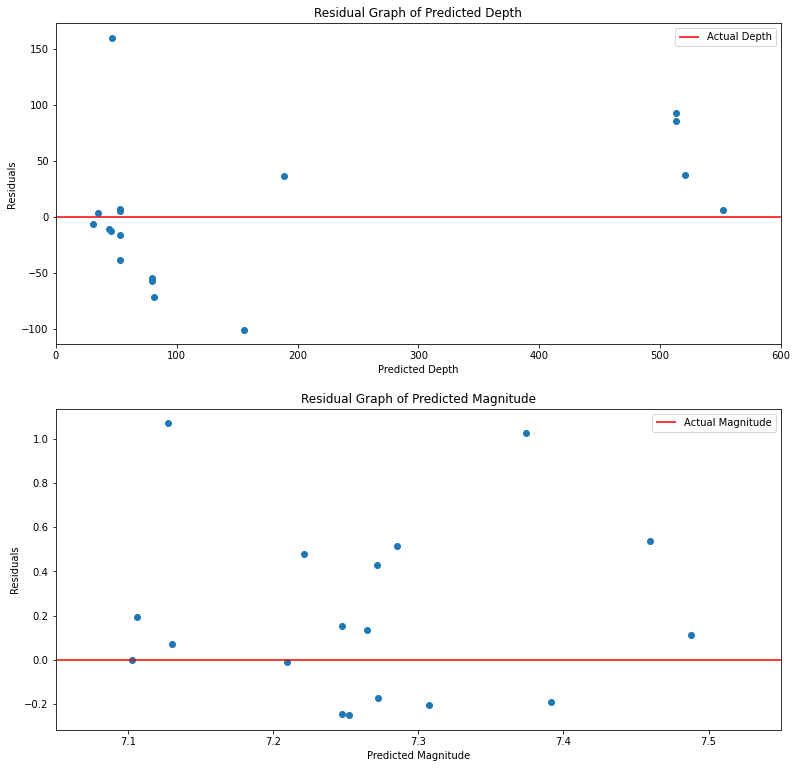

In [102]:
# creating our subplot
plt.subplots(2, 1, figsize=(13, 13))


# Visualizing distributions of residuals of predicted Depth on subplot 1
plt.subplot(2, 1, 1)
plt.scatter(y_pred[:,0],residuals.iloc[:,0])
plt.xlabel('Predicted Depth')
plt.ylabel('Residuals')
plt.hlines(0,0,600,color='r',label='Actual Depth')
plt.xlim((0,600))
plt.title('Residual Graph of Predicted Depth')
plt.legend()

# Visualizing distributions of residuals of predicted Magnitude on subplot 2
plt.subplot(2, 1, 2)
plt.scatter(y_pred[:,1],residuals.iloc[:,1])
plt.xlabel('Predicted Magnitude')
plt.ylabel('Residuals')
plt.hlines(0,7,8,color='r',label='Actual Magnitude')
plt.xlim((7.05,7.55))
plt.title('Residual Graph of Predicted Magnitude')
plt.legend()

plt.show()

It is apparent from the above residual plots that there is no real correlation between the residuals and the predicted values. This indicates that my predictive model is homoskedastic, meaning that there is a constant error margin at all predicted values. This is a good sign for the accuracy of our predictions, especially if I were to predict on values outside the range of the test data. One worrisome indication from this graph above is that the predicted depths appear to be somewhat bimodal, whereas the original dataset's depth feature was heavily concentrated in the lower numbers.

## Conclusion

In this notebook I began by attempting to create a time series to predict the length between and the lat/long of serious earthquakes. Unfortunately time did not allow me to  complete all the features that I hoped to create, and restructuring my data in a manner that allowed for a multivariate time series analysis would have significantly reduced the amount of time I had available to the rest of my project. Next, I trained and tested several models to predict earthquake depth and magnitude given date-time latitude and longitude. The models used were Linear Regression, Random Forest Regression, Gradient Boosting Regression, LightGBM Regression, and XGBoost Regression. These models were optimized through use of grid search and they were scored by the R squared value when comparing predicted y_test vs true y_test. Ultimately I found that of the optimized models, the Gradient Boosting Regression model slightly outscored the Random Forest Regressor and the XGBoost Regressor with an R squared value of 38.2%. I then checked the model for heteroskedasticity and found that there was no correlation between the residuals and predicted values.

With this in mind, I now will be taking my findings from this notebook to my final report where I will be presenting the business use-case for this regression and how it can help lessen the burden caused by natural seismic events.

## Next Steps

Going forward from here there are many things that I would try that time did not allow me to include in this project. One of the main things that I would include is a seismic activity prior to earthquake feature. Most of the state of the art current earthquake prediction models, such as the one used by the US Geological Survey, include seismic activity prior to large earthquakes in order to determine the presence of 'foreshocks', or smaller earthquakes that precede the 'mainshock' or serious earthquake. Additionally, going forward I would restructure my data such that a time series analysis would be possible in order to predict a latitudinal and longitudinal area that is overdue a serious earthquake. Another implementation that I would have liked to completed would be to have segmented the entire globe into smaller pieces similarly to the way I segmented off South America. This would have allowed me to train a model in each of these areas to determine if there are any intrinsically different features or feature relationships in other parts of the world.